# Recognizing Persian Digits

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import random
import utils
from PIL import Image
from IPython.display import display
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from scipy import ndimage
from __future__ import print_function
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

Using TensorFlow backend.


In [2]:
root = './data/Digits/isolated digits/'
binary_save_path = './binary_data/isolated digits/'
num_labels= 10
image_size = 28

## Contents
* Loading and Preprocessing Data

## Loading and Preprocessing Data

First we will load and normalize data, then we resize all of the images in (28,28) size and save it to binary .npy file :

In [3]:
data_paths = utils.maybe_save(root,binary_save_path,image_size)

./binary_data/isolated digits/0.npy already present - Skipping pickling.
./binary_data/isolated digits/1.npy already present - Skipping pickling.
./binary_data/isolated digits/2.npy already present - Skipping pickling.
./binary_data/isolated digits/3.npy already present - Skipping pickling.
./binary_data/isolated digits/4.npy already present - Skipping pickling.
./binary_data/isolated digits/5.npy already present - Skipping pickling.
./binary_data/isolated digits/6.npy already present - Skipping pickling.
./binary_data/isolated digits/7.npy already present - Skipping pickling.
./binary_data/isolated digits/8.npy already present - Skipping pickling.
./binary_data/isolated digits/9.npy already present - Skipping pickling.


Checking if data is Balanced across diffrent classes : 

In [4]:
def balancingCheck(data_folder) :
    tmpList = None
    for i,ds in enumerate(data_folder) :
        dataset = np.load(ds)
        print("number of images in %s is equal to %s" % (ds,len(dataset)))
balancingCheck(data_paths)

number of images in ./binary_data/isolated digits/0.npy is equal to 975
number of images in ./binary_data/isolated digits/1.npy is equal to 942
number of images in ./binary_data/isolated digits/2.npy is equal to 990
number of images in ./binary_data/isolated digits/3.npy is equal to 945
number of images in ./binary_data/isolated digits/4.npy is equal to 958
number of images in ./binary_data/isolated digits/5.npy is equal to 994
number of images in ./binary_data/isolated digits/6.npy is equal to 962
number of images in ./binary_data/isolated digits/7.npy is equal to 956
number of images in ./binary_data/isolated digits/8.npy is equal to 982
number of images in ./binary_data/isolated digits/9.npy is equal to 949


As you see data is almost balanced over diffrent classes.

Merging and Creating Label for datasets :

In [5]:
def merge_datasets(data_paths) :    
    data = np.concatenate([np.load(path) for path in data_paths],axis=0)
    label = np.concatenate([[path[-5]]*len(np.load(path)) for i,path in enumerate(data_paths)])
    return data,label
data,labels = merge_datasets(data_paths)

We should shuffle data for cnn trainer :

In [6]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
data,labels = randomize(data,labels)

We want to make sure that data still looks good :

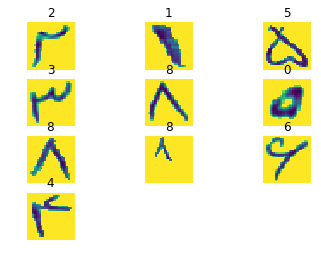

In [7]:
def visualize(dataset,labels,size = 10) :
    samples = np.random.randint(len(dataset),size=size)
    for i,sample in enumerate(samples) :
        plt.subplot(np.ceil(np.sqrt(size)),np.floor(np.sqrt(size)),1+i)
        plt.axis('off')
        plt.title(labels[sample])
        plt.imshow(dataset[sample])
visualize(data,labels,10)

In [8]:
def reformat(data,labels) :
    data = np.array(data).reshape((-1,image_size,image_size,1)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None].astype(np.float32))
    return data,labels

In [9]:
data,labels = reformat(data,labels)
print('shape of data : {}'.format(data.shape))
print('shape of labels : {}'.format(labels.shape))

shape of data : (9653, 28, 28, 1)
shape of labels : (9653, 10)


In [10]:
def train_valid_test_spliter(data,labels) :
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    return X_train,y_train,X_val,y_val,X_test,y_test

In [11]:
X_train,y_train,X_val,y_val,X_test,y_test = train_valid_test_spliter(data,labels)

In [13]:
print('train data shape: {}'.format(X_train.shape))
print('train labels shape: {}'.format(X_train.shape))
print('valid data shape : {}'.format(X_val.shape))
print('valid labels shape: {}'.format(y_val.shape))
print('test data shape : {}'.format(X_test.shape))
print('test labels shape: {}'.format(y_test.shape))

train data shape: (6177, 28, 28, 1)
train labels shape: (6177, 28, 28, 1)
valid data shape : (1545, 28, 28, 1)
valid labels shape: (1545, 10)
test data shape : (1931, 28, 28, 1)
test labels shape: (1931, 10)


In [12]:
def conv_model(input_shape) :
    
    model = Sequential()
    model.add(Conv2D(16, 5, padding='same', activation='selu', input_shape=input_shape))
    model.add(Conv2D(16, 5, padding='same', activation='selu'))
    model.add(Conv2D(16, 5, padding='same', activation='selu'))
    model.add(Conv2D(16, 5, padding='same', activation='selu'))
    model.add(Conv2D(16, 5, padding='same', activation='selu'))
    model.add(Conv2D(16, 5, padding='same', activation='selu'))
    model.add(Conv2D(16, 5, padding='same', activation='selu'))
    model.add(Conv2D(16, 5, padding='same', activation='selu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(32, 3, padding='same', activation='selu'))
    model.add(Conv2D(32, 3, padding='same', activation='selu'))
    model.add(Conv2D(32, 3, padding='same', activation='selu'))
    model.add(Conv2D(32, 3, padding='same', activation='selu'))
    model.add(Conv2D(32, 3, padding='same', activation='selu'))
    model.add(Conv2D(32, 3, padding='same', activation='selu'))
    model.add(Conv2D(32, 3, padding='same', activation='selu'))
    model.add(Conv2D(32, 3, padding='same', activation='selu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(64, 3, padding='same', activation='selu'))
    model.add(Conv2D(64, 3, padding='same', activation='selu'))
    model.add(Conv2D(64, 3, padding='same', activation='selu'))
    model.add(Conv2D(64, 3, padding='same', activation='selu'))
    model.add(Conv2D(64, 3, padding='same', activation='selu'))
    model.add(Conv2D(64, 3, padding='same', activation='selu'))
    model.add(Conv2D(64, 3, padding='same', activation='selu'))
    model.add(Conv2D(64, 3, padding='same', activation='selu'))
    model.add(AveragePooling2D())

    model.add(Flatten())

    model.add(Dense(1024, activation='selu'))
    model.add(Dense(1024, activation='selu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [14]:
model = conv_model((image_size,image_size,1))
model.fit(X_train,y_train,batch_size=64,epochs=100,validation_data=(X_val,y_val))

Train on 6177 samples, validate on 1545 samples
Epoch 1/100
6177/6177 [==============================] - 12s 2ms/step - loss: 0.6164 - acc: 0.7983 - val_loss: 0.2009 - val_acc: 0.9340
Epoch 2/100
6177/6177 [==============================] - 7s 1ms/step - loss: 0.1638 - acc: 0.9488 - val_loss: 0.1155 - val_acc: 0.9683
Epoch 3/100
6177/6177 [==============================] - 7s 1ms/step - loss: 0.1143 - acc: 0.9634 - val_loss: 0.1589 - val_acc: 0.9463
Epoch 4/100
6177/6177 [==============================] - 7s 1ms/step - loss: 0.0774 - acc: 0.9768 - val_loss: 0.1689 - val_acc: 0.9489
Epoch 5/100
6177/6177 [==============================] - 7s 1ms/step - loss: 0.0682 - acc: 0.9777 - val_loss: 0.1023 - val_acc: 0.9696
Epoch 6/100
6177/6177 [==============================] - 7s 1ms/step - loss: 0.0511 - acc: 0.9830 - val_loss: 0.0935 - val_acc: 0.9761
Epoch 7/100
6177/6177 [==============================] - 7s 1ms/step - loss: 0.0254 - acc: 0.9934 - val_loss: 0.0788 - val_acc: 0.9748
Epoch 

Epoch 60/100
6177/6177 [==============================] - 7s 1ms/step - loss: 9.8853e-06 - acc: 1.0000 - val_loss: 0.0695 - val_acc: 0.9871
Epoch 61/100
6177/6177 [==============================] - 7s 1ms/step - loss: 9.4836e-06 - acc: 1.0000 - val_loss: 0.0697 - val_acc: 0.9871
Epoch 62/100
6177/6177 [==============================] - 6s 1ms/step - loss: 9.0378e-06 - acc: 1.0000 - val_loss: 0.0695 - val_acc: 0.9877
Epoch 63/100
6177/6177 [==============================] - 6s 1ms/step - loss: 8.6723e-06 - acc: 1.0000 - val_loss: 0.0696 - val_acc: 0.9877
Epoch 64/100
6177/6177 [==============================] - 7s 1ms/step - loss: 8.3088e-06 - acc: 1.0000 - val_loss: 0.0698 - val_acc: 0.9877
Epoch 65/100
6177/6177 [==============================] - 6s 1ms/step - loss: 7.9593e-06 - acc: 1.0000 - val_loss: 0.0698 - val_acc: 0.9877
Epoch 66/100
6177/6177 [==============================] - 6s 1ms/step - loss: 7.6211e-06 - acc: 1.0000 - val_loss: 0.0700 - val_acc: 0.9877
Epoch 67/100
6177/61

In [15]:
scores = model.evaluate(X_test,y_test)

1931/1931 [==============================] - 1s 377us/step


In [18]:
print("Accuracy : %{}".format(scores[1]*100))
print("Error : %{}".format(100 - scores[1]*100))

Accuracy : %98.86069394096323
Error : %1.1393060590367696
